# notlar

### Varsayımlar:

1. Bütün orderlar aynı boyutta ve aynı ağırlıktadır. 
2. Her bir wave'de en fazla 8 farklı malzeme toplanabilir. Wave'ler için bir kapasite kısıtı yoktur.
3. O1 tipi siparişler için günlük toplama kapasitesi 25.000, O2 tipi için ise 175.000'dir.
4. Toplanması gereken miktarlar için 'datathon_picking' dosyasındaki 'Toplanan Miktar' sütunu baz alınmıştır
5. Siparişler günün başlangıcında alınır (08.00), teslimatlar gün sonunda yapılır (18:00).
6. Gelecek günlerden sipariş toplaması yapılabilir.
7. Aynı wave içerisinde farklı orderdan ürünler bulunabileceği gibi, aynı orderdan malzemeler farklı wavelerde bulunabilir. Paketleme sürecinde sipariş düzenleme işleminin halledildiği varsayılmaktadır. 
8. Bir sipariş içerisindeki bir sipariş kaleminde bulunan malzemeler bölünemez. (örn. 111 nolu siparişin 2 nolu kalemi A malz. 30 adet, bu farklı wavelerde toplanacak şekilde bölünemez.)
9. Gerçek hayatta thminler ne kadar iyi de olsa güvenilmez olduğu i  n sadece tahminlere göre topla/toplama kararı verilmiş, kesin siparişler harici tahminler üzerinden toplama yapılmamıştır. 

### Toplama algoritması adımları:

##### Terminoloji:

- wave : bir toplama operasyonudur, en fazla 8 farklı ürün içerebilir, kapasite kısıtı yoktur.                   
- checklist : kesinleşmiş siparişler listesidir.               
- must_pick : o gün toplanması gereken siparişler listesidir. Bütün siparişler en geç sevk tarihinde toplanmaktadır.           

##### Adımlar

Her bir gün için yap:

    1. O gün gelen siparişleri ve varsa henüz teslim edilmemiş eski siparişleri checklist'e ekle

    2. Checklist'te bulunan ve o gün teslim edilmesi gereken siparişleri must_pick listesine ekle ve checklist'ten must_pick listesini çıkar.

    3. Must_pick listesini topla
        3.0 must_pick listesini malzeme numarasına göre sırala
        3.1 Günlük kapasiteye kadar olan siparişleri 'normal' tipte topla
        3.2 Günlük kapasite üzeri siparişleri 'overwork' olarak topla

    4. Eğer wave'lerde boş yer kaldıysa ve günlük kapasite dolmadıysa ekstra toplama yap (wave kısıtı 8 farklı malzeme toplamak olduğu için bu doldurulana kadar toplama yapılabilir.)
        4.0 checklist'i aynı tipteki materyaller ve diğerleri olarak ayır ve teslim tarihine göre sırala
        4.1 checklist'te kalan aynı tipteki malzemeleri topla (wave'i efektif kullanmak adına)
        4.2 Hala yer kaldıysa checklist'te bulunan en yakın tarihli malzeleri bul. Eğer bu malzemeler için teslim tarihinden önce yeni bir sipariş gelmesi beklenmiyorsa (tahminleri kullanarak) günlük kısıtı aşmayacak şekilde topla.

    5. Hala günlük kapasite varsa ekstra toplama yap
        5.0 checklist'i kontrol ederek gelecek günlerde bir darboğaz olup olmayacağını kontrol et.
        5.1 Eğer darboğaz varsa günlük kısıtı aşmayacak şekilde toplama yapmaya devam et.

    6. Sonuçları yazdır.

### can be improved by:

1. balance the workload, not 10,1,3,22 waves for 4 days, should be 8,9,9,10
2. minimize the workload for sunday
3. add holidays

In [1]:
import pandas as pd
from tqdm import tqdm
import time

In [2]:
picking_data_path = r'data/datathon_picking.csv'

In [3]:
picking_df = pd.read_csv(picking_data_path, index_col='Unnamed: 0')

C:\Users\IsmailKaraman\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (1,5,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
picking_df.head()

,Siparis No,Siparis Tipi,Urun Kodu,Toplanan Miktar,Toplama Tarihi,Toplama Saati,Siparişin Düştüğü Tarih,Sevkiyat Tarihi,Müşteri,Operasyon Numarası
0,72616784,10.0,61000058,45,28122019,11:10,26122019,2012020,C10005,O1
1,72616784,10.0,61000058,45,28122019,11:11,26122019,2012020,C10005,O1
2,72616784,10.0,61000058,45,28122019,11:11,26122019,2012020,C10005,O1
3,72616784,10.0,61000058,45,28122019,11:12,26122019,2012020,C10005,O1
4,72616784,10.0,61000058,45,28122019,11:10,26122019,2012020,C10005,O1


In [5]:
picking_df.columns = ['order_num', 'order_type', 'material_num', 'order_amount', 'picking_date', 
                      'picking_hour', 'order_receive_date', 'shipping_date', 'customer_num', 'operation_type']

In [6]:
# from analysis we saw that customer number 'C-10170' is replaced with 'C-10277', so we replace all the values
picking_df.replace('C-10170', 'C-10277', inplace=True)

In [7]:
picking_df.head()

,order_num,order_type,material_num,order_amount,picking_date,picking_hour,order_receive_date,shipping_date,customer_num,operation_type
0,72616784,10.0,61000058,45,28122019,11:10,26122019,2012020,C10005,O1
1,72616784,10.0,61000058,45,28122019,11:11,26122019,2012020,C10005,O1
2,72616784,10.0,61000058,45,28122019,11:11,26122019,2012020,C10005,O1
3,72616784,10.0,61000058,45,28122019,11:12,26122019,2012020,C10005,O1
4,72616784,10.0,61000058,45,28122019,11:10,26122019,2012020,C10005,O1


In [8]:
def convert_string_to_date(str_date):
    
    str_date = str(str_date)
    str_date = str_date.replace('/','')
    str_date = str_date.replace('.','')
    
    len_date = len(str_date)
    
    if len_date>7:
        return pd.Timestamp(int(str_date[4:]), int(str_date[2:4]), int(str_date[:2]))   
    elif len_date==7:
        return pd.Timestamp(int(str_date[3:]), int(str_date[1:3]), int(str_date[:1]))   
    elif len_date==6:
        return pd.Timestamp(int(str_date[2:]), int(str_date[1:2]), int(str_date[:1]))   

In [9]:
picking_df['picking_date'] = picking_df['picking_date'].apply(convert_string_to_date)
picking_df['order_receive_date'] = picking_df['order_receive_date'].apply(convert_string_to_date)
picking_df['shipping_date'] = picking_df['shipping_date'].apply(convert_string_to_date)
picking_df['picking_hour'] = pd.to_datetime(picking_df['picking_hour'])

In [10]:
picking_df.shape

(712390, 10)

In [11]:
picking_df['time_for_shipping'] = (picking_df['shipping_date'] - picking_df['order_receive_date']).dt.days

<AxesSubplot:>

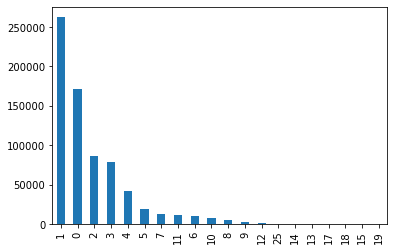

In [12]:
picking_df['time_for_shipping'].value_counts().plot(kind='bar')

In [13]:
avg_prod_shipping = pd.DataFrame()
avg_prod_shipping['avg_shipping_time'] = picking_df.groupby('material_num').agg({'time_for_shipping':'mean'})['time_for_shipping']
avg_prod_shipping['shipping_count'] = picking_df.groupby('material_num').agg({'time_for_shipping':'count'})['time_for_shipping']
avg_prod_shipping = avg_prod_shipping.sort_values('avg_shipping_time').reset_index()
avg_prod_shipping.query('avg_shipping_time == 0 and shipping_count > 10')
# orders for below products are immediate

,material_num,avg_shipping_time,shipping_count
2,PL07872A,0.0,54
5,TR00818B,0.0,13
14,TR02034B,0.0,17
19,CN06559A,0.0,13
22,61010324,0.0,29


In [14]:
avg_cust_shipping = pd.DataFrame()
avg_cust_shipping['avg_shipping_time'] = picking_df.groupby('customer_num').agg({'time_for_shipping':'mean'})['time_for_shipping']
avg_cust_shipping['shipping_count'] = picking_df.groupby('customer_num').agg({'time_for_shipping':'count'})['time_for_shipping']
avg_cust_shipping = avg_cust_shipping.sort_values('avg_shipping_time').reset_index()
avg_cust_shipping.query('avg_shipping_time == 0 and shipping_count > 10')
# below customers give their orders immediate, same day shipping

,customer_num,avg_shipping_time,shipping_count
0,M982,0.0,32
2,M788,0.0,13
4,C10282,0.0,51
6,C10244,0.0,36
7,M597,0.0,20
10,M961,0.0,28
12,M147,0.0,11
13,M98,0.0,45
18,M449,0.0,17


In [15]:
df = picking_df[['order_num', 'material_num', 'order_receive_date', 'shipping_date',
                 'customer_num', 'operation_type', 'order_amount']].copy()

In [16]:
df.sort_values(by=['order_receive_date', 'order_num'], inplace=True)

In [17]:
df.head()

,order_num,material_num,order_receive_date,shipping_date,customer_num,operation_type,order_amount
0,72616784,61000058,2019-12-26,2020-01-02,C10005,O1,45
1,72616784,61000058,2019-12-26,2020-01-02,C10005,O1,45
2,72616784,61000058,2019-12-26,2020-01-02,C10005,O1,45
3,72616784,61000058,2019-12-26,2020-01-02,C10005,O1,45
4,72616784,61000058,2019-12-26,2020-01-02,C10005,O1,45


<AxesSubplot:>

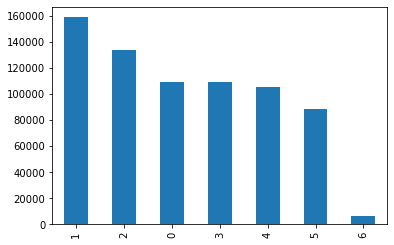

In [18]:
df['shipping_date'].dt.weekday.value_counts().plot(kind='bar')

In [19]:
def receive_orders(orders, date):
    
    checklist = pd.DataFrame()
    new_orders = orders[orders['order_receive_date']==date]
    checklist = pd.concat([checklist, new_orders], axis=0).sort_values(by='shipping_date')
        
    return checklist

In [20]:
def add_picking_list(picking_list, row, num_wave, date, picking_type):

    row_picking = {}
    row_picking['wave_no'] = num_wave
    row_picking['material'] = row['material_num']
    row_picking['order_num'] = row['order_num']
    row_picking['picking_date'] = date
    row_picking['shipping_date'] = row['shipping_date']
    row_picking['customer_num'] = row['customer_num']
    row_picking['order_receive_date'] = row['order_receive_date']
    row_picking['operation_type'] = row['operation_type']
    row_picking['picking_type'] = picking_type
    row_picking['amount'] = row['order_amount']
    picking_list = pd.concat([picking_list, pd.DataFrame([row_picking])])
    
    return picking_list

In [21]:
def create_wave(checklist, num_wave, picking_list, date, picking_type):
    
    wave_materials_set = set()
    wave_total_amount = 0
    
    for idx, row in checklist.iterrows():
            
        mat_num = row['material_num']
        amount = row['order_amount']  
        
        if len(wave_materials_set) < 8:
            # if (daily_capacity-amount)>=0:
            wave_materials_set.add(mat_num)
            wave_total_amount += amount
            picking_list = add_picking_list(picking_list, row, num_wave, date, picking_type)
            checklist.drop(idx, axis=0, inplace=True)   
            # else: continue
        
        elif len(wave_materials_set) == 8:
            # if (daily_capacity-amount)>=0:
            if mat_num in wave_materials_set:
                wave_materials_set.add(mat_num)
                wave_total_amount += amount
                picking_list = add_picking_list(picking_list, row, num_wave, date, picking_type)
                checklist.drop(idx, axis=0, inplace=True)  
            #else: continue    
        else:   
            break   
    remain_wave = 8-len(wave_materials_set)
        
    return checklist, picking_list.reset_index(drop=True), wave_materials_set, wave_total_amount

In [22]:
def check_future_predictions(mat_num, date, shipping_date):
    
    future_preds = df.query(f"material_num == '{mat_num}' and order_receive_date > '{date}' and shipping_date <= '{shipping_date}'")
    
    if len(future_preds) > 0:
        return False
    else:
        return True

In [23]:
def check_bottleneck(checklist, daily_capacity):
    
    tmp_sums = checklist.groupby(['shipping_date'])['order_amount'].sum()
    bottleneck_dates = tmp_sums[tmp_sums>daily_capacity].index
    
    return bottleneck_dates

In [24]:
def complete_wave(checklist, picking_list, num_wave, date, picking_type, wave_materials_set, wave_total_amount, daily_capacity):
    
    same_materials = checklist[checklist['material_num'].isin(wave_materials_set)].sort_values(by=['shipping_date', 'material_num'])
    checklist = checklist[~checklist['material_num'].isin(wave_materials_set)].sort_values(by=['shipping_date', 'material_num'])
    
    if len(same_materials)>0:
        
        for idx, row in same_materials.iterrows():
            
            amount = row['order_amount'] 
            if daily_capacity-amount >= 0:
                
                wave_total_amount += amount
                daily_capacity -= amount
                picking_list = add_picking_list(picking_list, row, num_wave, date, picking_type)
                same_materials.drop(idx, axis=0, inplace=True)  
            else:
                continue
                
    if daily_capacity > 0 and len(checklist) > 0:       
            
        for idx, row in checklist.iterrows():
            
            amount = row['order_amount'] 
            mat_num = row['material_num']
            
            pick_suggestion_flag = check_future_predictions(mat_num, date, row['shipping_date'])
            
            if (daily_capacity-amount >= 0) and pick_suggestion_flag:
                
                wave_materials_set.add(mat_num)
                wave_total_amount += amount
                daily_capacity -= amount
                picking_list = add_picking_list(picking_list, row, num_wave, date, picking_type)
                checklist.drop(idx, axis=0, inplace=True)  

                if len(wave_materials_set) == 8 or daily_capacity == 0:
                    break
            else:
                continue
                
    if len(same_materials)>0:
        checklist = pd.concat([checklist, same_materials])
        
    return checklist, picking_list, wave_total_amount, daily_capacity

In [25]:
def sort_checklist_by_amount(checklist):
    
    sorter = checklist.groupby('material_num')['order_amount'].sum().sort_values(ascending=False).index
    sorterIndex = dict(zip(sorter, range(len(sorter))))
    checklist['mat_rank'] = checklist['material_num'].map(sorterIndex)
    checklist.sort_values(['mat_rank'], inplace = True)
    checklist.drop('mat_rank', 1, inplace = True)
    
    return checklist

In [26]:
def pick_orders(orders, checklist, picking_list, daily_capacity, date):
    
    # receiving daily orders
    new_orders = receive_orders(orders, date)
    checklist = pd.concat([checklist, new_orders])
    checklist['time_for_shipping'] = (checklist['shipping_date'] - date).dt.days  
    # creating must_pick orders list
    must_pick = checklist[checklist['time_for_shipping']==0].sort_values(by=['material_num'])
    # deleting must_pick orders from checklist
    checklist = checklist[checklist['time_for_shipping']>0].sort_values(by=['time_for_shipping'])
    
    num_wave = 0
    wave_materials_set = set()
    wave_total_amount = 0
    
    # pick all the materials that should be shipped today, even its greater than daily capacity do overwork to handle it
    while len(must_pick) > 0:
        
        num_wave += 1
        if daily_capacity > 0:
            picking_type = 'normal'
        elif daily_capacity <= 0:
            picking_type = 'overwork'
        
        must_pick, picking_list, wave_materials_set, wave_total_amount = create_wave(must_pick, num_wave, picking_list, date, picking_type)
        daily_capacity -= wave_total_amount
    
    # if there are some uncomplete waves, complete by picking next orders that has no future predictions
    if (0 <  len(wave_materials_set) < 8) and (daily_capacity > 0) and (len(checklist) > 0):
        
        picking_type = 'utilize_wave'
        checklist, picking_list, wave_total_amount, daily_capacity = complete_wave(checklist, picking_list, num_wave, date, picking_type, wave_materials_set, wave_total_amount, daily_capacity)
        daily_capacity -= wave_total_amount
    
    smallest_amount = checklist['order_amount'].min()
    
    while (daily_capacity >= smallest_amount) and (len(checklist) > 0):
        
        num_wave += 1
        
        picking_type = 'resolve_bottleneck'
        bottleneck_dates = check_bottleneck(checklist, daily_capacity)
        
        if len(bottleneck_dates) > 0:
            
            closest_bottleneck = sorted(bottleneck_dates)[0]
            
            bottleneck_checklist = checklist[checklist['shipping_date']<=closest_bottleneck] 
            checklist = checklist[checklist['shipping_date']>closest_bottleneck] 
            
            bottleneck_checklist = sort_checklist_by_amount(bottleneck_checklist)
            bottleneck_checklist, picking_list, wave_materials_set, wave_total_amount = create_wave(bottleneck_checklist, num_wave, picking_list, date, picking_type)
            daily_capacity -= wave_total_amount
            
            checklist = pd.concat([checklist, bottleneck_checklist])
            smallest_amount = bottleneck_checklist['order_amount'].min()
        else: 
            break

    return picking_list, checklist, daily_capacity

In [27]:
def picking(orders, daily_capacity):
    
    picking_list = pd.DataFrame()
    checklist = pd.DataFrame()
    left_capacities = []
    # for date in pd.date_range(df['order_receive_date'].min(), df['order_receive_date'].max()):
    for date in tqdm(pd.date_range(orders['order_receive_date'].min(), orders['order_receive_date'].max())):    

        # updating checklist
        picking_list, checklist, left_daily_capacity = pick_orders(orders, checklist, picking_list, daily_capacity, date)
        left_capacities.append(left_daily_capacity)

    return picking_list

### O1

In [28]:
df_O1 = df[df['operation_type']=='O1']
capacity_for_O1 = 25000
# run picking algorithm
picking_plans_O1 = picking(df_O1, capacity_for_O1)

100%|██████████████████████████████████████████████████████████████████████████████| 371/371 [2:23:26<00:00, 23.20s/it]


In [29]:
average_daily_picking = picking_plans_O1.groupby(['picking_date'])['amount'].sum()
print()
print('O1 Operasyon Tipi')
print()
print('-------------------------------------------')
print(f"Günlük toplama miktarı istatisikleri : ")
print(f"Ortalama toplama miktarı:    {average_daily_picking.mean():.2f}" )
print(f"std:                         {average_daily_picking.std():.2f}")
print(f"min:                         {average_daily_picking.min():.2f}")
print(f"max:                         {average_daily_picking.max():.2f}")
print(f"Ortalama kapasite kullanımı: % {100*average_daily_picking.mean()/25000:.2f}" )
print('-------------------------------------------')
wave_utilization = picking_plans_O1.groupby(['picking_date', 'wave_no'])['material'].nunique()
print(f"Wave verimlilik istatistikleri : ")
print(f"(Not: Her bir wave max 8 tip ürün alabilmektedir)")
print(f"Ortalama doluluk oranı :      {wave_utilization.mean():.2f}, ")
print(f"std                           {wave_utilization.std():.2f}, ")
print(f"min:                          {wave_utilization.min():.2f}, ")
print(f"max:                          {wave_utilization.max():.2f}")
print(f"Ortalama kapasite kullanımı : % {wave_utilization.mean()/8:.2f}, ")


O1 Operasyon Tipi

-------------------------------------------
Günlük toplama miktarı istatisikleri : 
Ortalama toplama miktarı:    22733.03
std:                         10145.96
min:                         691.00
max:                         57677.00
Ortalama kapasite kullanımı: % 90.93
-------------------------------------------
Wave verimlilik istatistikleri : 
(Not: Her bir wave max 8 tip ürün alabilmektedir)
Ortalama doluluk oranı :      7.94, 
std                           0.55, 
min:                          1.00, 
max:                          8.00
Ortalama kapasite kullanımı : % 0.99, 


### O2

In [ ]:
df_O2 = df[df['operation_type']=='O2']
capacity_for_O2 = 175000
# run picking algorithm
picking_plans_O2 = picking(df_O2, capacity_for_O2)

 68%|███████████████████████████████████████████████████▋                        | 247/363 [2:20:56<1:33:52, 48.56s/it]

In [2]:
import pandas as pd
picking_plans_O1 = pd.read_csv('sub_O1.csv')
picking_plans_O2 = pd.read_csv('plans_O2.csv')

C:\Users\IsmailKaraman\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
average_daily_picking = picking_plans_O2.groupby(['picking_date'])['amount'].sum()
print()
print('O2 Operasyon Tipi')
print()
print('-------------------------------------------')
print(f"Günlük toplama miktarı istatisikleri : ")
print(f"Ortalama toplama miktarı:    {average_daily_picking.mean():.2f}" )
print(f"std:                         {average_daily_picking.std():.2f}")
print(f"min:                         {average_daily_picking.min():.2f}")
print(f"max:                         {average_daily_picking.max():.2f}")
print(f"Ortalama kapasite kullanımı: % {100*average_daily_picking.mean()/175000:.2f}" )
print('-------------------------------------------')
wave_utilization = picking_plans_O2.groupby(['picking_date', 'wave_no'])['material'].nunique()
print(f"Wave verimlilik istatistikleri : ")
print(f"(Not: Her bir wave max 8 tip ürün alabilmektedir)")
print(f"Ortalama doluluk oranı :      {wave_utilization.mean():.2f}, ")
print(f"std                           {wave_utilization.std():.2f}, ")
print(f"min:                          {wave_utilization.min():.2f}, ")
print(f"max:                          {wave_utilization.max():.2f}")
print(f"Ortalama kapasite kullanımı : % {wave_utilization.mean()/8:.2f}, ")


O2 Operasyon Tipi

-------------------------------------------
Günlük toplama miktarı istatisikleri : 
Ortalama toplama miktarı:    169811.61
std:                         94026.17
min:                         482.00
max:                         845696.00
Ortalama kapasite kullanımı: % 97.04
-------------------------------------------
Wave verimlilik istatistikleri : 
(Not: Her bir wave max 8 tip ürün alabilmektedir)
Ortalama doluluk oranı :      7.93, 
std                           0.60, 
min:                          1.00, 
max:                          8.00
Ortalama kapasite kullanımı : % 0.99, 


### submission format

In [5]:
sub_O1 = picking_plans_O1.groupby(['picking_date', 'wave_no', 'material']).agg({'operation_type':'max', 'picking_type':'max',
                                                                                'amount':'sum'}).reset_index()

In [6]:
sub_O2 = picking_plans_O2.groupby(['picking_date', 'wave_no', 'material']).agg({'operation_type':'max', 'picking_type':'max',
                                                                                'amount':'sum'}).reset_index()

In [7]:
sub = pd.concat([sub_O1, sub_O2])
sub.sort_values(by=['picking_date', 'wave_no'], inplace=True)
sub.columns = ['Toplama Tarihi', 'Wave Number', 'Malzeme No', 'Operasyon No', 'Toplama Türü', 'Toplama Miktarı']
sub[['Wave Number', 'Operasyon No', 'Malzeme No', 'Toplama Miktarı','Toplama Tarihi', 'Toplama Türü']].to_csv('submission_DataButchers.csv')